In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [2]:
!nvidia-smi

Fri May  8 10:05:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [4]:
!gsutil cp gs://resnet_simclr_imagenet/20200508-091658resnet_simclr.h5 .

Copying gs://resnet_simclr_imagenet/20200508-091658resnet_simclr.h5...
| [1 files][ 92.3 MiB/ 92.3 MiB]                                                
Operation completed over 1 objects/92.3 MiB.                                     


In [0]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [0]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [4]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [5]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [7]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

  9%|▉         | 22/250 [00:00<00:01, 210.92it/s]

(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 187.91it/s]


(250, 224, 224, 3) (250,)


In [0]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [0]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)

    resnet_simclr = Model(inputs, projection_2)

    return resnet_simclr

In [25]:
resnet_simclr = get_resnet_simclr(256, 128)
resnet_simclr.load_weights("/content/20200508-091658resnet_simclr.h5")
resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
Total params: 24,145,152
Trainable params: 24,092,032
Non-trainable params: 53,120
__________________________________________

In [0]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [11]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


In [0]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
2/2 [==============================] - 0s 64ms/step - loss: 2.6441 - accuracy: 0.1840 - val_loss: 2.5938 - val_accuracy: 0.1480
Epoch 2/35
2/2 [==============================] - 0s 23ms/step - loss: 2.4391 - accuracy: 0.2160 - val_loss: 2.4380 - val_accuracy: 0.1760
Epoch 3/35
2/2 [==============================] - 0s 23ms/step - loss: 2.2553 - accuracy: 0.2160 - val_loss: 2.3100 - val_accuracy: 0.1880
Epoch 4/35
2/2 [==============================] - 0s 24ms/step - loss: 2.1000 - accuracy: 0.2480 - val_loss: 2.2061 - val_accuracy: 0.2000
Epoch 5/35
2/2 [==============================] - 0s 23ms/step - loss: 1.9690 - accuracy: 0.2800 - val_loss: 2.1243 - val_accuracy: 0.2160
Epoch 6/35
2/2 [==============================] - 0s 27ms/step - loss: 1.8635 - accuracy: 0.3200 - val_loss: 2.0585 - val_accuracy: 0.2280
Epoch 7/35
2/2 [==============================] - 0s 23ms/step - loss: 1.7729 - accuracy: 0.3120 - val_loss: 2.0038 - val_accuracy: 0.2160
Epoch 8/35
2/2 [===========

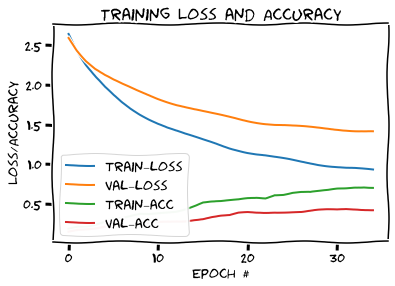

In [24]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [26]:
# Encoder model with no projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


Epoch 1/35
2/2 [==============================] - 0s 64ms/step - loss: 1.9048 - accuracy: 0.2080 - val_loss: 1.9608 - val_accuracy: 0.2880
Epoch 2/35
2/2 [==============================] - 0s 25ms/step - loss: 1.8215 - accuracy: 0.3200 - val_loss: 1.7038 - val_accuracy: 0.3040
Epoch 3/35
2/2 [==============================] - 0s 25ms/step - loss: 1.5381 - accuracy: 0.4000 - val_loss: 1.4364 - val_accuracy: 0.3560
Epoch 4/35
2/2 [==============================] - 0s 24ms/step - loss: 1.3559 - accuracy: 0.4240 - val_loss: 1.3165 - val_accuracy: 0.4440
Epoch 5/35
2/2 [==============================] - 0s 24ms/step - loss: 1.2765 - accuracy: 0.4720 - val_loss: 1.2853 - val_accuracy: 0.4640
Epoch 6/35
2/2 [==============================] - 0s 22ms/step - loss: 1.1686 - accuracy: 0.5440 - val_loss: 1.3424 - val_accuracy: 0.4800
Epoch 7/35
2/2 [==============================] - 0s 24ms/step - loss: 1.1476 - accuracy: 0.5840 - val_loss: 1.3325 - val_accuracy: 0.5120
Epoch 00007: early stopping

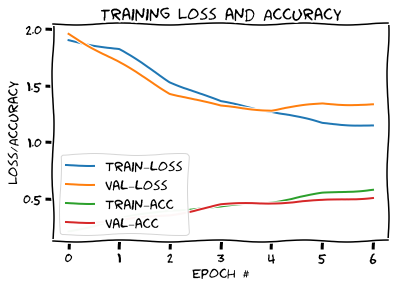

In [27]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)